In [ ]:
from fastai.vision import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image
from sklearn.model_selection import KFold
import random
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
from sklearn.metrics import precision_score
DATA_PATH="/content/lazydata/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.cuda.empty_cache() 
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Thu Dec 15 02:29:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+------

In [ ]:
!unzip /content/drive/MyDrive/ml/testX.pt.zip -d /content/ 

Archive:  /content/drive/MyDrive/ml/testX.pt.zip
replace /content/testX.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip /content/drive/MyDrive/ml/lazydata-20221208T200112Z-001.zip -d /content/ 

Archive:  /content/drive/MyDrive/ml/lazydata-20221208T200112Z-001.zip
replace /content/lazydata/test/X/561/field_id.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
class LazyLoadDataset(Dataset):
    def trim(depth):
        equalized = cv2.equalizeHist(depth)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(equalized)

        # Set the lower and upper thresholds for trimming
        lower_threshold = min_val + 0.05 * (max_val - min_val)
        upper_threshold = max_val - 0.05 * (max_val - min_val)

        # Discard the top and bottom 5% of the data
        trimmed = cv2.threshold(equalized, lower_threshold, upper_threshold, 0)

        # Find the new minimum and maximum intensity values
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(trimmed)

        # Perform min-max normalization
        normalized = cv2.normalize(trimmed, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    def __init__(self,path,train=True,transform=None):
        self.transform=transform
        path=path+("train/" if train else "test/")
        
        self.pathX=path+"X/"
        self.pathY=path+"Y/"
        
        self.data=os.listdir(self.pathX)
        
    def __getitem__(self,idx):
        f=self.data[idx]
        
        #X
        #read rgb images
        img0=cv2.imread(self.pathX+f+"/rgb/0.png")
        img1=cv2.imread(self.pathX+f+"/rgb/1.png")
        img2=cv2.imread(self.pathX+f+"/rgb/2.png")
        if self.transform is not None:
            img0=self.transform(Image.fromarray(img0))
            img1=self.transform(Image.fromarray(img1))
            img2=self.transform(Image.fromarray(img2))
     
        depth=np.load(self.pathX+f+"/depth.npy")
      
        field_id=pkl.load(open(self.pathX+f+"/field_id.pkl","rb"))
     
        Y=np.load(self.pathY+f+".npy")
        
        return (img0,img1,img2,depth/1000,field_id),Y*1000
    def __len__(self):
        return len(self.data)

In [ ]:
def train(epoch, model, optimizer):
    model.train()
    losss=[]
    for batch_idx, (data, target) in enumerate(train_loader):#inside loop: shape of data is [64,224,224,9] target is [64,12]


        RGBs=torch.stack((data[0][:,0,:,:],data[0][:,1,:,:],data[0][:,2,:,:],data[1][:,0,:,:],data[1][:,1,:,:],data[1][:,2,:,:],data[2][:,0,:,:],data[2][:,1,:,:],data[2][:,2,:,:]),1)
        depth=data[3]
        depth=(depth-min_d)/(max_d-min_d)
        data=torch.cat((RGBs,depth), 1)
        data, target = data.to(device), target.to(device)

        output = model(data)
        mse_loss = nn.MSELoss()
        loss = mse_loss(output.float(), target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losss.append(loss.item())
    print(np.mean(losss))


In [ ]:
transforms_train = transforms.Compose([
    transforms.ColorJitter(brightness=.3,contrast=0.3,hue=.3), 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

In [ ]:
def get_min_and_max_depth(data):
  min_depth, max_depth = float("inf"),0
  for image, tmp in data:
    img0, img1, img2, depth, field_id = image
    single_min = np.mean(depth)
    single_max = np.max(depth)
    min_depth=single_min if single_min<min_depth else min_depth
    max_depth=single_max if single_min>max_depth else max_depth
  return min_depth, max_depth

In [ ]:
tmp_data=LazyLoadDataset(DATA_PATH,True)
min_d,max_d=get_min_and_max_depth(tmp_data)
train_dataset=LazyLoadDataset(DATA_PATH,True, transforms_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
(min_d,max_d)

(0.82528, 65.535)

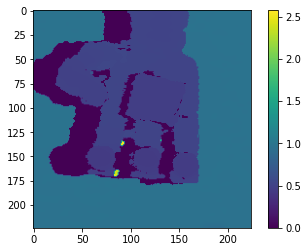

In [ ]:
plt.imshow(train_dataset[121][0][3][0])
plt.colorbar()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet152(pretrained=True)   
weight=model.conv1.weight.clone()
model.conv1 = nn.Conv2d(12, 64, kernel_size=7)
with torch.no_grad():
    model.conv1.weight[:,:3]=weight
    model.conv1.weight[:,3]=model.conv1.weight[:,0]
num_features = model.fc.in_features    
model.fc = nn.Linear(num_features, 12) 
model=nn.DataParallel(model)
model.to(device)
criterion = nn.MSELoss()  #(set loss function)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                    step_size=1,
#                                                    gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.cuda.empty_cache()
for epoch in range(0, 70):
    train(epoch, model, optimizer)
#     lr_scheduler.step()
#     test(model)

In [ ]:
    # for batch_idx, (data, target) in enumerate(train_loader):#inside loop: shape of data is [64,224,224,9] target is [64,12]


    #     RGBs=torch.stack((data[0][:,0,:,:],data[0][:,1,:,:],data[0][:,2,:,:],data[1][:,0,:,:],data[1][:,1,:,:],data[1][:,2,:,:],data[2][:,0,:,:],data[2][:,1,:,:],data[2][:,2,:,:]),1)
    #     depth=data[3]
    #     depth=(depth-min_d)/(max_d-min_d)
    #     print(depth)
    #     break

In [ ]:
open("/content/model","w")
torch.save(model, "/content/model")


In [ ]:
# model = torch.load("/content/model")

In [ ]:
# class LazyLoadDataset_test(Dataset):
#     def __init__(self,path,train=True,transform=None):
#         self.transform=transform
#         path=path+("test/")
        
#         self.pathX=path+"X/"
     
        
#         self.data=os.listdir(self.pathX)
        
#     def __getitem__(self,idx):
#         f=self.data[idx]
        
#         #X
#         #read rgb images
#         img0=cv2.imread(self.pathX+f+"/rgb/0.png")
#         img1=cv2.imread(self.pathX+f+"/rgb/1.png")
#         img2=cv2.imread(self.pathX+f+"/rgb/2.png")
#         if self.transform is not None:
#             img0=self.transform(Image.fromarray(img0))
#             img1=self.transform(Image.fromarray(img1))
#             img2=self.transform(Image.fromarray(img2))
#         #read image depth
#         depth=np.load(self.pathX+f+"/depth.npy")
#         #read field ID
        
#         field_id=pkl.load(open(self.pathX+f+"/field_id.pkl","rb"))
#         #Y
       
        
# #         #normalize rgb 0-255
# #         img0=cv2.normalize(img0, None, alpha=0, beta=1,
# #                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         img1=cv2.normalize(img1, None, alpha=0, beta=1,
# #                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         img2=cv2.normalize(img2, None, alpha=0, beta=1,
# #                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         depth=cv2.normalize(depth/1000, None, alpha=0, beta=1,
# #                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
#         return img0,img1,img2,depth/1000,field_id
#     def __len__(self):
#         return len(self.data)

In [ ]:
# transforms_test = transforms.Compose([
# #     transforms.ColorJitter(brightness=.3,contrast=0.3,hue=.3), # data augmentation
#     transforms.ToTensor(),
#     # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalization
# ])
# test_d=LazyLoadDataset_test(DATA_PATH,True, transforms_test)
# test_loader = torch.utils.data.DataLoader(test_d, batch_size=1, shuffle=False)


In [ ]:
from tqdm import tqdm

In [ ]:


def normalize_tensor(tensor):
    mean = tensor.mean()
    std = tensor.std()
    normalized_tensor = (tensor - mean) / std
    normalized_tensor = 0.5 * (normalized_tensor / 0.5) + 0.5

    return normalized_tensor


In [ ]:
# preds = []
# file_ids=[]
# for (data) in tqdm(test_loader):#inside loop: shape of data is [64,224,224,9] target is [64,12]
#         # send to device
#         #reshape data from [64,224,224,9] to [64,9,224,224]

#         RGBs=torch.stack((data[0][:,0,:,:],data[0][:,1,:,:],data[0][:,2,:,:],
#                           data[1][:,0,:,:],data[1][:,1,:,:],data[1][:,2,:,:],
#                           data[2][:,0,:,:],data[2][:,1,:,:],data[2][:,2,:,:]),1)
#         #concate depth
#         inn=torch.cat((RGBs,data[3]), 1)
        
#         # data = data.to(device)

#         output = model(inn)
#         preds.append(output.cpu().detach().numpy())
#         file_ids.append(data[-1][0])

In [ ]:
test_data = torch.load('/content/testX.pt')
file_ids = test_data[-1]
depth_data=test_data[1]/1000
depth_data=(depth_data-min_d)/(max_d-min_d)
rgb_data = test_data[0]
rgb_data[:,0]=normalize_tensor(rgb_data[:,0])
rgb_data[:,1]=normalize_tensor(rgb_data[:,1])
rgb_data[:,2]=normalize_tensor(rgb_data[:,2])
new_test=torch.cat((rgb_data[:,0],rgb_data[:,1],rgb_data[:,2],depth_data),dim=1)
rgb_data[:,2].shape

torch.Size([849, 3, 224, 224])

In [ ]:
# aa=test_data[1]/1000
# bb=(aa-min_d)/(max_d-min_d)
# bb

In [ ]:
depth_data

tensor([[[[ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
          [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
          [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
          ...,
          [ 0.0020,  0.0021,  0.0021,  ...,  0.0023,  0.0023,  0.0023],
          [ 0.0019,  0.0020,  0.0021,  ...,  0.0022,  0.0022,  0.0023],
          [ 0.0019,  0.0020,  0.0021,  ...,  0.0022,  0.0022,  0.0022]],

         [[ 0.0157, -0.0128, -0.0128,  ..., -0.0128, -0.0128, -0.0128],
          [ 0.0157, -0.0128, -0.0128,  ..., -0.0128, -0.0128, -0.0128],
          [ 0.0159, -0.0128, -0.0128,  ..., -0.0128, -0.0128, -0.0128],
          ...,
          [ 0.0017,  0.0017,  0.0018,  ...,  0.0008,  0.0008,  0.0008],
          [ 0.0017,  0.0017,  0.0018,  ...,  0.0008,  0.0008,  0.0008],
          [ 0.0017,  0.0017,  0.0018,  ...,  0.0008,  0.0008,  0.0008]],

         [[ 0.0235,  0.0228,  0.0224,  ...,  0.0466,  0.0469,  0.0472],
          [ 0.0232,  0.0227,  

In [ ]:
split_test=torch.split(new_test,5,dim=0)
preds = []
for data in tqdm(split_test):
    # Please remember to modify this loop, input and output based on your model/architecture
    output = model(data)
    preds.append(output.cpu().detach().numpy()/1000)

100%|██████████| 170/170 [00:07<00:00, 22.40it/s]


In [ ]:
import pickle
import pandas as pd
# model=model_cnn
outfile = '/content/out.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

# test_data = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt')
file_ids = test_data[-1]
# depth_data=test_data[1]
# rgb_data = test_data[0]
# model.eval()
# new_test=torch.cat((rgb_data[:,0],rgb_data[:,1],rgb_data[:,2],depth_data),dim=1)
# split_test=torch.split(new_test,100,dim=0)
# for data in split_test:
#     # Please remember to modify this loop, input and output based on your model/architecture
#     output = model(data.to('cuda'))
#     preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(np.concatenate(preds))], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file /content/out.csv


In [ ]:
df

,ID,FINGER_POS_1,FINGER_POS_2,FINGER_POS_3,FINGER_POS_4,FINGER_POS_5,FINGER_POS_6,FINGER_POS_7,FINGER_POS_8,FINGER_POS_9,FINGER_POS_10,FINGER_POS_11,FINGER_POS_12
0,146,0.049949,0.052382,0.120513,0.055146,0.000273,0.116482,0.067199,-0.053297,0.102544,0.050549,0.032086,-0.044161
1,1474,0.044438,0.053474,0.120828,0.037784,-0.000080,0.125113,0.037577,-0.056280,0.128869,0.053176,0.042141,-0.036849
2,190,0.049199,0.052962,0.122678,0.082618,-0.002069,0.094010,0.045188,-0.040969,-0.017099,0.060214,0.038496,-0.039771
3,1544,0.047385,0.053092,0.112071,0.061520,-0.001804,0.101508,0.073931,-0.052448,0.097279,0.048981,0.050606,-0.026215
4,952,0.057916,0.051814,0.110039,0.077338,-0.001631,0.095259,0.089907,-0.040567,0.027763,0.058488,0.052136,-0.021543
...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2647,0.045396,0.054515,0.125953,0.070016,-0.002723,0.098490,0.075598,-0.044305,0.039550,0.051826,0.040719,-0.028590
845,3970,0.045581,0.053086,0.121230,0.074780,0.000851,0.092464,0.070901,-0.046276,0.032689,0.056352,0.036889,-0.048131
846,1597,0.053151,0.053440,0.120700,0.066723,-0.002044,0.107142,0.054817,-0.056148,0.120138,0.049171,0.061153,-0.010331
847,421,0.048729,0.052783,0.118872,0.062439,-0.001681,0.104430,0.065293,-0.040294,0.011413,0.053153,0.043004,-0.034737
